# Day-Ahead Forecast of Electric Vehicle Charging Demand with Deep Neural Networks

by Winston Chiong

The contents of this Jupyter Notebook is based partially off the paper:

***[Day-Ahead Forecast of Electric Vehicle Charging Demand with Deep Neural Networks](https://www.mdpi.com/2032-6653/12/4/178)***

*by Gilles Van Kriekinge, Cedric De Cauwer, Nikolaos Sapountzoglou and Thierry Coosemans and Maarten Messagie*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
import openmeteo_requests
import requests_cache
import plotly.graph_objects as go
from retry_requests import retry
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

sns.set_style("white")

In [2]:
hourlydemand = pd.read_csv("../data/hourlydemand.csv", index_col="time", parse_dates=True)
hourlydemand = hourlydemand.drop(columns=["avg_power_demand_kW", "peak_power_kW"])
hourlydemand

,energy_demand_kWh,day,month
time,,,
2020-11-05 10:00:00,0.439500,Thursday,November
2020-11-05 11:00:00,0.879000,Thursday,November
2020-11-05 12:00:00,0.879000,Thursday,November
2020-11-05 13:00:00,0.879000,Thursday,November
2020-11-05 14:00:00,0.293000,Thursday,November
...,...,...,...
2024-05-05 17:00:00,6.361667,Sunday,May
2024-05-05 18:00:00,5.089333,Sunday,May
2024-05-05 19:00:00,0.000000,Sunday,May


## Data Normalization

In the paper, two different normalization techniques were tested, *z-score* and *min-max* normalization. *Min-max* normalization generally has the better performance, and its formula is defined as
$$x_N = \frac{x_t - x_{min}}{x_{max} - x_{min}}$$
where $x_t$ is the non-normalized datapoint, $x_{min}$ is the minimum value, and $x_{max}$ is the maximum value of all datapoints.

In [3]:
scaler = MinMaxScaler()
hourlydemand['norm_energy_demand_kWh'] = scaler.fit_transform(hourlydemand[['energy_demand_kWh']])
hourlydemand.drop(columns=["energy_demand_kWh"], inplace=True)
hourlydemand

,day,month,norm_energy_demand_kWh
time,,,
2020-11-05 10:00:00,Thursday,November,0.011382
2020-11-05 11:00:00,Thursday,November,0.022763
2020-11-05 12:00:00,Thursday,November,0.022763
2020-11-05 13:00:00,Thursday,November,0.022763
2020-11-05 14:00:00,Thursday,November,0.007588
...,...,...,...
2024-05-05 17:00:00,Sunday,May,0.164746
2024-05-05 18:00:00,Sunday,May,0.131797
2024-05-05 19:00:00,Sunday,May,0.000000


## Features

We include various load, calendar, and weather features to augment our dataframe. The list of features is given below.

- **Load**
    - The previous day's EV charging demand (1 datapoint for each hour) [kWh]
    - The same hour 2 days ago's EV charging demand [kWh]
    - The same hour 3 days ago's EV charging demand [kWh]
    - The same hour 7 days ago's EV charging demand [kWh]
- **Calendar**
    - Hour numnber [/]
    - Day number [/]
    - Binary working day [0 or 1]
    - Binary holiday [0 or 1]
- **Weather**
    - Daily temperature [°C]
    - Daily rainfall [mm/h]

In [4]:
hourlydemand["working_day"] = hourlydemand["day"].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
hourlydemand['hour_number'] = hourlydemand.index.hour
hourlydemand['day_number'] = hourlydemand.index.dayofweek # Monday: 0, Sunday: 6

holidays = USFederalHolidayCalendar().holidays(start=hourlydemand.index.min(), end=hourlydemand.index.max()) # US holidays
hourlydemand["holiday"] = hourlydemand.index.normalize().isin(holidays).astype(int)

lags = list(range(24, 48)) + [48, 72, 168] # the entire previous day, the same hour 2, 3, and 7 days ago
for i in lags: 
    hourlydemand[f"lag{i}"] = hourlydemand["norm_energy_demand_kWh"].shift(i)
hourlydemand.dropna(inplace=True)

hourlydemand.drop(columns=["day", "month"], inplace=True)
hourlydemand

,norm_energy_demand_kWh,working_day,hour_number,day_number,holiday,lag24,lag25,lag26,lag27,lag28,...,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag72,lag168
time,,,,,,,,,,,,,,,,,,,,,
2020-11-12 10:00:00,0.000000,1,10,3,0,0.126764,0.126764,0.126764,0.042255,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011382
2020-11-12 11:00:00,0.000000,1,11,3,0,0.126764,0.126764,0.126764,0.126764,0.042255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763
2020-11-12 12:00:00,0.000000,1,12,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763
2020-11-12 13:00:00,0.000000,1,13,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763
2020-11-12 14:00:00,0.000000,1,14,3,0,0.073946,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-05 17:00:00,0.164746,0,17,6,0,0.000000,0.068400,0.164159,0.013680,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205058,0.000000
2024-05-05 18:00:00,0.131797,0,18,6,0,0.091802,0.000000,0.068400,0.164159,0.013680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.180759,0.000000
2024-05-05 19:00:00,0.000000,0,19,6,0,0.157374,0.091802,0.000000,0.068400,0.164159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


We can use the Open-Meteo API to obtain temperature and precipitation data. We can then join these results with our main dataframe.

In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 37.866989, # RSF Parking Lot (slrpEV)
	"longitude": -122.272507, # RSF Parking Lot (slrpEV)
	"start_date": hourlydemand.index.min().strftime('%Y-%m-%d'),
	"end_date": hourlydemand.index.max().strftime('%Y-%m-%d'),
	"hourly": ["temperature_2m", "precipitation"],
	"timezone": "America/Los_Angeles"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()

hourly_weather_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_weather_data["temperature_2m"] = hourly_temperature_2m
hourly_weather_data["precipitation"] = hourly_precipitation

# create hourly weather data, join with main dataframe
hourly_weather_data = pd.DataFrame(data = hourly_weather_data).set_index("date", drop=True)
hourly_weather_data.index = pd.to_datetime(hourly_weather_data.index.strftime("%Y-%m-%d %H:%M:%S"))
hourlydemand = pd.merge(hourlydemand, hourly_weather_data, left_index=True, right_index=True, how='inner')
hourlydemand

Coordinates 37.85588455200195°N -122.21180725097656°E
Elevation 48.0 m asl
Timezone b'America/Los_Angeles' b'PDT'
Timezone difference to GMT+0 -25200 s


,norm_energy_demand_kWh,working_day,hour_number,day_number,holiday,lag24,lag25,lag26,lag27,lag28,...,lag43,lag44,lag45,lag46,lag47,lag48,lag72,lag168,temperature_2m,precipitation
2020-11-12 10:00:00,0.000000,1,10,3,0,0.126764,0.126764,0.126764,0.042255,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011382,6.778500,0.0
2020-11-12 11:00:00,0.000000,1,11,3,0,0.126764,0.126764,0.126764,0.126764,0.042255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763,6.328500,0.0
2020-11-12 12:00:00,0.000000,1,12,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763,5.728500,0.0
2020-11-12 13:00:00,0.000000,1,13,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022763,5.528500,0.0
2020-11-12 14:00:00,0.000000,1,14,3,0,0.073946,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007588,5.228500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-05 17:00:00,0.164746,0,17,6,0,0.000000,0.068400,0.164159,0.013680,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205058,0.000000,12.078500,0.0
2024-05-05 18:00:00,0.131797,0,18,6,0,0.091802,0.000000,0.068400,0.164159,0.013680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.180759,0.000000,13.428500,0.0
2024-05-05 19:00:00,0.000000,0,19,6,0,0.157374,0.091802,0.000000,0.068400,0.164159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,14.728499,0.0
2024-05-05 20:00:00,0.000000,0,20,6,0,0.157374,0.157374,0.091802,0.000000,0.068400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15.578500,0.0


Two of the calendar features, hour number (denoted $\Delta T$) and day number (denoted $D$), have a periodicity that the neural network does not directly understand. For instance, after 23h00 (timestep = 23) follows 00h00 (timestep = 0) and after Sunday (day = 6) follows Monday (day = 0). To overcome this issue, the initial features are transformed into cyclical values (sines and cosines) using the below equations for hours and day numbers.

$$\Delta T_{sin/cos} = \{
\begin{array}{ll}
sin(\Delta T \times 2\pi \times \frac{1}{24}) \\
cos(\Delta T \times 2\pi \times \frac{1}{24})
\end{array}$$

$$D_{sin/cos} = \{
\begin{array}{ll}
sin(D \times 2\pi \times \frac{1}{7}) \\
cos(D \times 2\pi \times \frac{1}{7})
\end{array}$$


In [6]:
# Apply cyclical transformation to hour_number
hourlydemand['hour_sin'] = np.sin(2 * np.pi * hourlydemand['hour_number'] / 24)
hourlydemand['hour_cos'] = np.cos(2 * np.pi * hourlydemand['hour_number'] / 24)

# Apply cyclical transformation to day_number
hourlydemand['day_sin'] = np.sin(2 * np.pi * hourlydemand['day_number'] / 7)
hourlydemand['day_cos'] = np.cos(2 * np.pi * hourlydemand['day_number'] / 7)

hourlydemand

,norm_energy_demand_kWh,working_day,hour_number,day_number,holiday,lag24,lag25,lag26,lag27,lag28,...,lag47,lag48,lag72,lag168,temperature_2m,precipitation,hour_sin,hour_cos,day_sin,day_cos
2020-11-12 10:00:00,0.000000,1,10,3,0,0.126764,0.126764,0.126764,0.042255,0.000000,...,0.0,0.0,0.000000,0.011382,6.778500,0.0,5.000000e-01,-8.660254e-01,0.433884,-0.900969
2020-11-12 11:00:00,0.000000,1,11,3,0,0.126764,0.126764,0.126764,0.126764,0.042255,...,0.0,0.0,0.000000,0.022763,6.328500,0.0,2.588190e-01,-9.659258e-01,0.433884,-0.900969
2020-11-12 12:00:00,0.000000,1,12,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.000000,0.022763,5.728500,0.0,1.224647e-16,-1.000000e+00,0.433884,-0.900969
2020-11-12 13:00:00,0.000000,1,13,3,0,0.126764,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.000000,0.022763,5.528500,0.0,-2.588190e-01,-9.659258e-01,0.433884,-0.900969
2020-11-12 14:00:00,0.000000,1,14,3,0,0.073946,0.126764,0.126764,0.126764,0.126764,...,0.0,0.0,0.000000,0.007588,5.228500,0.0,-5.000000e-01,-8.660254e-01,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-05 17:00:00,0.164746,0,17,6,0,0.000000,0.068400,0.164159,0.013680,0.000000,...,0.0,0.0,0.205058,0.000000,12.078500,0.0,-9.659258e-01,-2.588190e-01,-0.781831,0.623490
2024-05-05 18:00:00,0.131797,0,18,6,0,0.091802,0.000000,0.068400,0.164159,0.013680,...,0.0,0.0,0.180759,0.000000,13.428500,0.0,-1.000000e+00,-1.836970e-16,-0.781831,0.623490
2024-05-05 19:00:00,0.000000,0,19,6,0,0.157374,0.091802,0.000000,0.068400,0.164159,...,0.0,0.0,0.000000,0.000000,14.728499,0.0,-9.659258e-01,2.588190e-01,-0.781831,0.623490
2024-05-05 20:00:00,0.000000,0,20,6,0,0.157374,0.157374,0.091802,0.000000,0.068400,...,0.0,0.0,0.000000,0.000000,15.578500,0.0,-8.660254e-01,5.000000e-01,-0.781831,0.623490


## LSTM Configuration

The batch size is a trade-off between training speed and accuracy. The smaller the batch size, the faster the convergence will be. However, larger batches can reach lower minima than smaller batches. In addition, the batch size can also be chosen in function of the nature of the data. A batch size of two weeks is used.

The characteristics of the neural network is listed below. 

| Parameters          | LSTM      | 
|---------------------|-----------|
| Epochs              | 100       |
| Batch Size          | 336       |
| Optimizer           | Adam      |
| Loss function       | MSE       |
| Learning rate       | 0.001 *   |
| Hidden Neurons      | 30 **     |
| Activation function | Tanh **   |
| Dropout             | 0.3 **    |



## Train and Test Split

Let's reserve the last 20% of our data for test and 80% for training + validation. Within the training + vaildation set, let's split that up so that 80% of the train + validation is for training the last 20% is for validation. 

The split: 64% train + 16% validation + 20% test.

In [7]:
# split into train+validation and test
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    hourlydemand.drop(columns=["norm_energy_demand_kWh"]),
    hourlydemand[["norm_energy_demand_kWh"]],
    test_size=0.2, 
    shuffle=False
)

# split into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_validation, 
    y_train_validation,
    test_size = 0.2, 
    shuffle=False
)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Training LSTM Model

### Initialization
Here, we define our model configuration, train our model, and calculate losses.

In [8]:
# Define the parameters
lstm_config = {
    "epochs": 50,
    "batch_size": 24*14,
    "optimizer": Adam(learning_rate=0.001),
    "loss": MeanSquaredError(),
    "hidden_neurons": 30,
    "activation_function": 'tanh',
    "dropout": 0.3
}

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(lstm_config["hidden_neurons"], activation=lstm_config["activation_function"]))
model.add(Dropout(lstm_config["dropout"]))
model.add(Dense(1))
model.compile(optimizer=lstm_config["optimizer"], loss=lstm_config["loss"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         8,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,191 (32.00 KB)

 Trainable params: 8,191 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training

Here, we train our model. The layers of the neural networks used here are interconnected by weights which need to be defined during the training of the neural networks. Weights connected to the input layer can be analyzed in order to have an understanding on how the neural networks interact with the features. To do so, the algorithm Variance-based feature Importance in Artificial Neural Networks (VIANN) is applied to analyze the importance of the features. The importance of the features is calcualted based on a simple underlying principle of allocating a higher importance to bigger weights and weights which are more susceptible to variations during training.

In [9]:
class VarImpVIANN(keras.callbacks.Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        self.n = 0
        self.M2 = 0.0

    def on_train_begin(self, logs={}, verbose = 1):
        if self.verbose:
            print("VIANN version 1.0 (Wellford + Mean) update per epoch")
        self.diff = self.model.layers[0].get_weights()[0]
        
    def on_epoch_end(self, batch, logs={}):
        currentWeights = self.model.layers[0].get_weights()[0]
        
        self.n += 1
        delta = np.subtract(currentWeights, self.diff)
        self.diff += delta/self.n
        delta2 = np.subtract(currentWeights, self.diff)
        self.M2 += delta*delta2
            
        self.lastweights = self.model.layers[0].get_weights()[0]

    def on_train_end(self, batch, logs={}):
        if self.n < 2:
            self.s2 = float('nan')
        else:
            self.s2 = self.M2 / (self.n - 1)
        
        scores = np.sum(np.multiply(self.s2, np.abs(self.lastweights)), axis = 1)
        
        self.varScores = (scores - min(scores)) / (max(scores) - min(scores))
        if self.verbose:
            print("Most important variables: ",
                  np.array(self.varScores).argsort()[-10:][::-1])

In [10]:
VIANN = VarImpVIANN(verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=lstm_config["epochs"], batch_size=lstm_config["batch_size"], validation_data=(X_validation, y_validation), callbacks=[VIANN])

VIANN version 1.0 (Wellford + Mean) update per epoch
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0578 - val_loss: 0.0172
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0141
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0133
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0127
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0121
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - val_loss: 0.0114
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0118
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 12/50
59/59 ━━━

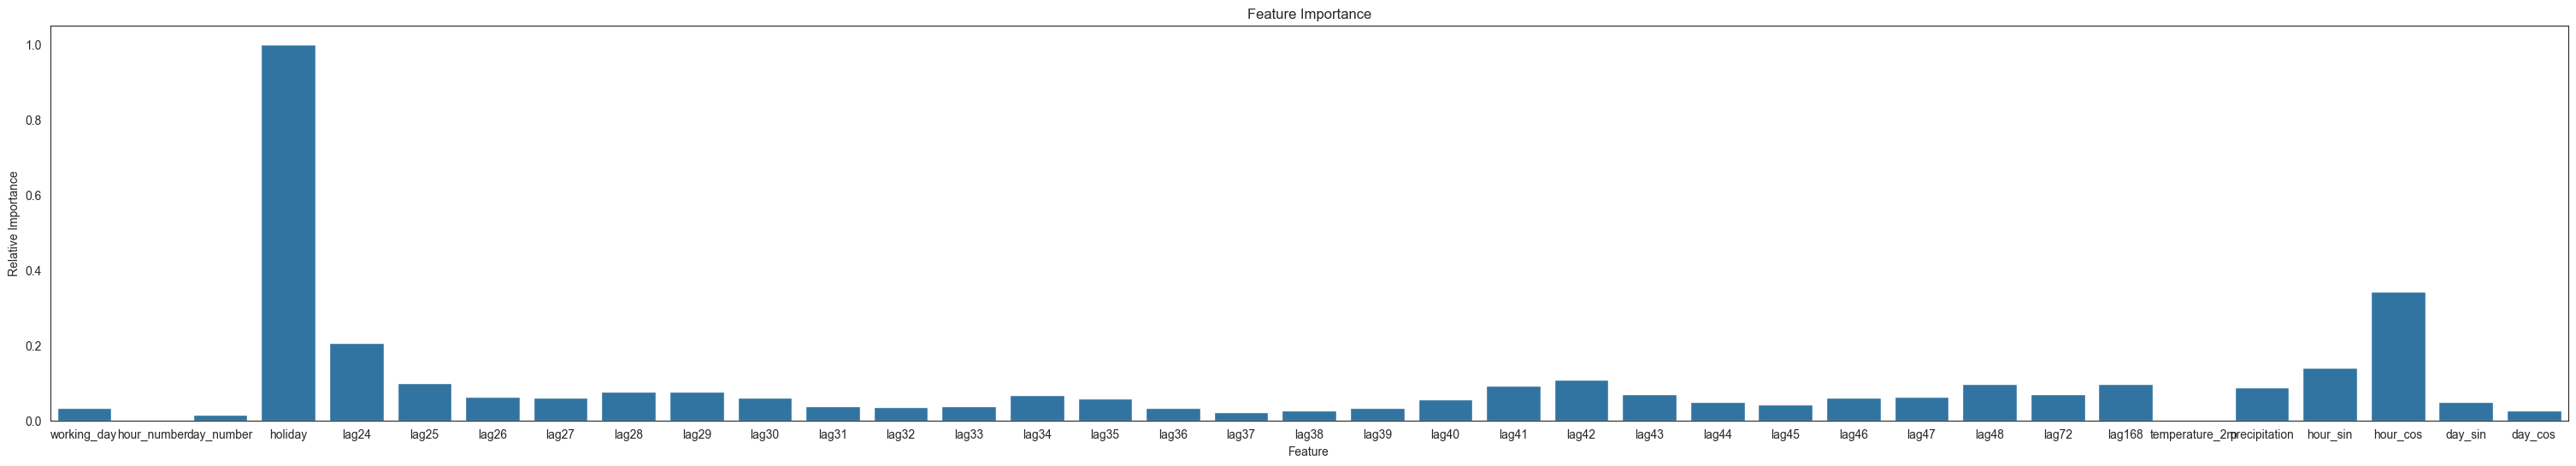

In [11]:
plt.figure(figsize=(len(hourlydemand.columns), 6))
sns.barplot(x=hourlydemand.columns[1:], y=VIANN.varScores)
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

### Training & Validation Loss

We expect our training and validation losses to converge; our validation loss decreases as our epochs increase, but saturate after some time.

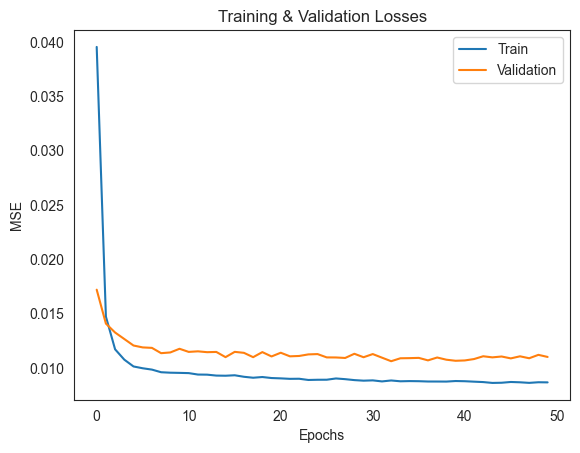

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0146
Validation Loss:  0.011007077991962433


In [12]:
# plot history
sns.lineplot(history.history['loss'], label='Train')
sns.lineplot(history.history['val_loss'], label='Validation')
plt.title("Training & Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
print("Validation Loss: ", model.evaluate(X_validation, y_validation))

### Model Performance & Post-Processing 

As a post-processing step, we set any negative predictions and predictions between 12AM - 5AM to zero. 

We evaluate our model on the test set we withheld. Our model performs modestly, slightly better than kNN.

In [13]:
yhat = model.predict(X_test)
y_test["yhat_norm_energy_demand_kWh"] = yhat
y_test["hour"] = y_test.index.hour

# post-processing
y_test["yhat_norm_energy_demand_kWh"] = y_test.apply(lambda row: 0 if row["hour"] <= 5 else row["yhat_norm_energy_demand_kWh"], axis=1) # 12AM - 5AM are all zero
y_test["yhat_norm_energy_demand_kWh"] = y_test.apply(lambda row: max(0, row["yhat_norm_energy_demand_kWh"]), axis=1)
y_test.drop(columns=["hour"], inplace=True)

# reverse min-max transformation
y_test["yhat_energy_demand_kWh"] = y_test["yhat_norm_energy_demand_kWh"].apply(lambda x: scaler.inverse_transform(np.array([[x]]))[0][0])
y_test["energy_demand_kWh"] = y_test["norm_energy_demand_kWh"].apply(lambda x: scaler.inverse_transform([[x]])[0][0])

y_test

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,norm_energy_demand_kWh,yhat_norm_energy_demand_kWh,yhat_energy_demand_kWh,energy_demand_kWh
2023-08-25 19:00:00,0.000000,0.047058,1.817147,0.000000
2023-08-25 20:00:00,0.000000,0.029811,1.151138,0.000000
2023-08-25 21:00:00,0.094490,0.023097,0.891908,3.648750
2023-08-25 22:00:00,0.040496,0.021475,0.829240,1.563750
2023-08-25 23:00:00,0.000000,0.018996,0.733513,0.000000
...,...,...,...,...
2024-05-05 17:00:00,0.164746,0.019816,0.765179,6.361667
2024-05-05 18:00:00,0.131797,0.019041,0.735257,5.089333
2024-05-05 19:00:00,0.000000,0.015857,0.612325,0.000000
2024-05-05 20:00:00,0.000000,0.017759,0.685770,0.000000


In [14]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_test["energy_demand_kWh"], name="Test Set")
)
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_test["yhat_energy_demand_kWh"], name="LSTM Forecast", line={"color":"red"})
)
fig.update_layout({"title" : f"Hourly Energy Demand Forecast -- LSTM" , "yaxis_title" : "Energy Demand (kWh)"})
fig.show()
print(f"Test Set RMSE: {root_mean_squared_error(y_test['energy_demand_kWh'], y_test['yhat_energy_demand_kWh'])} kWh")

Test Set RMSE: 4.507148383197361 kWh


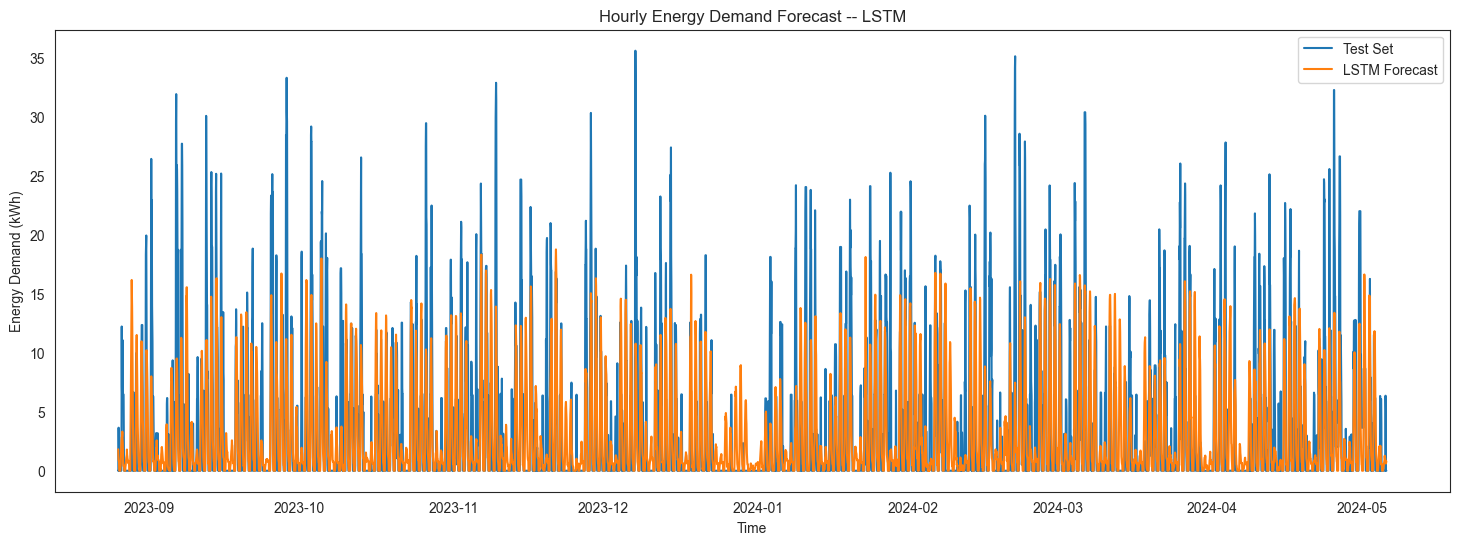

In [16]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=y_test.index, y=y_test["energy_demand_kWh"], label="Test Set")
sns.lineplot(x=y_test.index, y=y_test["yhat_energy_demand_kWh"], label="LSTM Forecast")
plt.title("Hourly Energy Demand Forecast -- LSTM")
plt.xlabel("Time")
plt.ylabel("Energy Demand (kWh)")
plt.legend()
plt.show()

## Discussion

The maximum values indicate the high variability in average charging power where maximum values can go up to 35+ kW which is 5-7 times higher than the mean value. The EV charging sessions demonstrate high stochastic behavior.

The weekly average EV charging demand is also shown below. The Christmas periods are characterized by low EV charging demand.

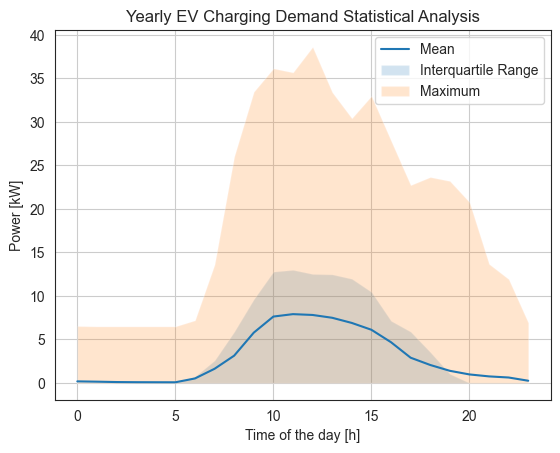

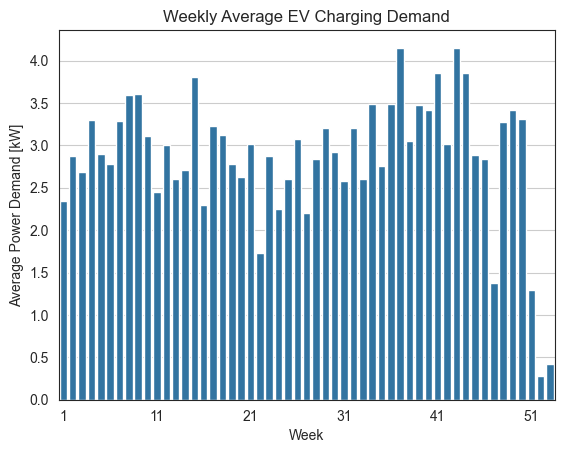

In [17]:
# Plot hourly demand breakdown
df = pd.read_csv("../data/hourlydemand.csv", index_col="time", parse_dates=True)
df['hour'] = df.index.hour

# Group by hour and calculate mean, quartiles, and maximum values
summary = df.groupby('hour')['avg_power_demand_kW'].agg(['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75), 'max'])

# Plot mean, quartiles (25th and 75th percentiles), maximum
sns.lineplot(x=summary.index, y=summary['mean'], label='Mean')
plt.fill_between(summary.index, summary['<lambda_0>'], summary['<lambda_1>'], alpha=0.2, label='Interquartile Range')
plt.fill_between(summary.index, summary['max'], alpha=0.2, label='Maximum')

plt.xlabel('Time of the day [h]')
plt.ylabel('Power [kW]')
plt.title('Yearly EV Charging Demand Statistical Analysis')
plt.grid(True)
plt.legend()
plt.show()

# Plot weekly demand
df = pd.read_csv("../data/dailydemand.csv", index_col="time", parse_dates=True)
df["week"] = df.index.isocalendar().week
df = df.groupby("week")[["avg_power_demand_kW"]].mean()

# create a bar chart for each week 
sns.barplot(data=df, x='week', y='avg_power_demand_kW')
plt.xticks(range(0, 52, 10))
plt.xlabel('Week')
plt.ylabel('Average Power Demand [kW]')
plt.title('Weekly Average EV Charging Demand')
plt.grid(axis='y')
plt.show()

## Future

Look into hour-ahead forecasting, using the values from the previous hours to forecast the next hour. This should be highly accurate, as it's already accurate to copy the previous to use as the prediction.